In [1]:
# Environment Setup

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rc('font', size='14')

import seaborn as sns

from datetime import datetime, timedelta
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

import json

from pprint import pprint

from os import path

import requests

import prepare
import explore
import model

# Acquire

- Create a dataframe from a manually created CSV file (lower cased column headers and copied and pasted all values from excel) of the activity data. The activity data was acquired during the project requirements phase.

In [2]:
df = pd.read_csv('activity_data.csv')

In [3]:
df.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


In [4]:
df.describe()

,distance,floors,minutes_lightly_active,minutes_fairly_active,minutes_very_active
count,225.000000,225.000000,225.000000,225.000000,225.000000
mean,4.046800,12.591111,188.235556,14.920000,33.871111
std,2.506253,25.844174,75.170001,15.363535,37.195986
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.220000,2.000000,158.000000,3.000000,2.000000
50%,3.680000,7.000000,203.000000,11.000000,15.000000
75%,5.900000,13.000000,236.000000,21.000000,63.000000
max,12.000000,195.000000,349.000000,78.000000,154.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
date                      225 non-null object
calories_burned           225 non-null object
steps                     225 non-null object
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null object
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 17.7+ KB


In [6]:
df.isna().sum()

date                      0
calories_burned           0
steps                     0
distance                  0
floors                    0
minutes_sedentary         0
minutes_lightly_active    0
minutes_fairly_active     0
minutes_very_active       0
activity_calories         0
dtype: int64

In [7]:
df.isnull().sum()

date                      0
calories_burned           0
steps                     0
distance                  0
floors                    0
minutes_sedentary         0
minutes_lightly_active    0
minutes_fairly_active     0
minutes_very_active       0
activity_calories         0
dtype: int64

# Prepare

- Explore the data types of the data set

**Note:** numeric values are assigned object types

In [8]:
df.dtypes

date                       object
calories_burned            object
steps                      object
distance                  float64
floors                      int64
minutes_sedentary          object
minutes_lightly_active      int64
minutes_fairly_active       int64
minutes_very_active         int64
activity_calories          object
dtype: object

- Create prepare.py file that contains a function which transforms the data in the following ways:


1. Set date to datetime
2. Set date to index
3. Remove commas from several columns
4. Convert data types of non-numeric data types to numeric data types

In [9]:
prep_df = prepare.prep_data(df)

In [10]:
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
calories_burned           225 non-null int64
steps                     225 non-null int64
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null int64
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null int64
dtypes: float64(1), int64(8)
memory usage: 17.6 KB


In [11]:
prep_df.head()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124
2018-04-29,2851,1639,0.77,0,891,122,0,0,602
2018-04-30,2825,1323,0.62,0,880,104,0,0,540


# Explore

- First observe at a high level any observations before diving deeper into any characteristics of the owner of the data.

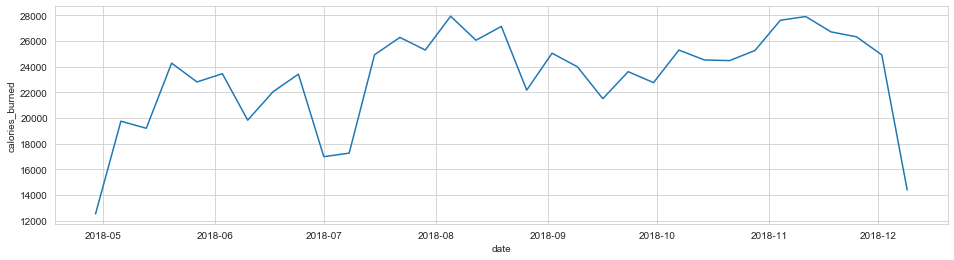

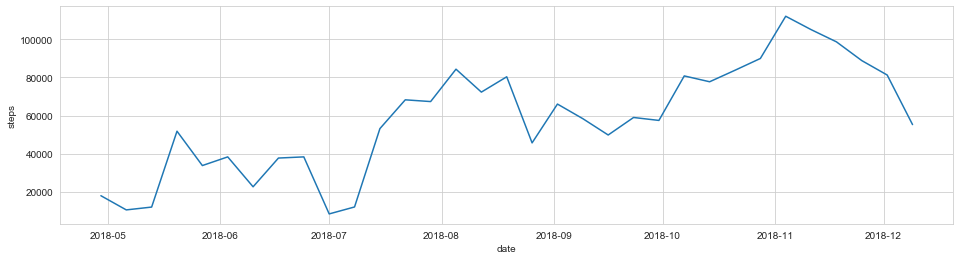

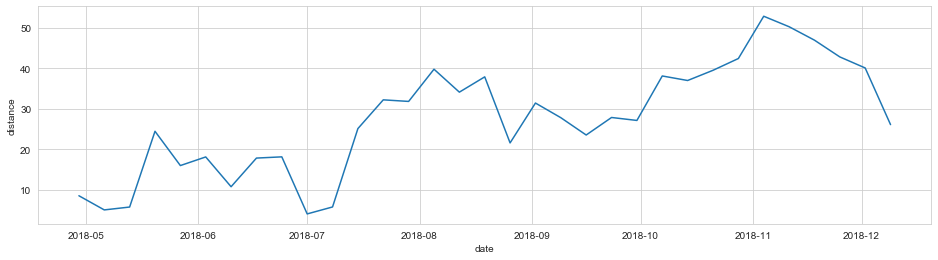

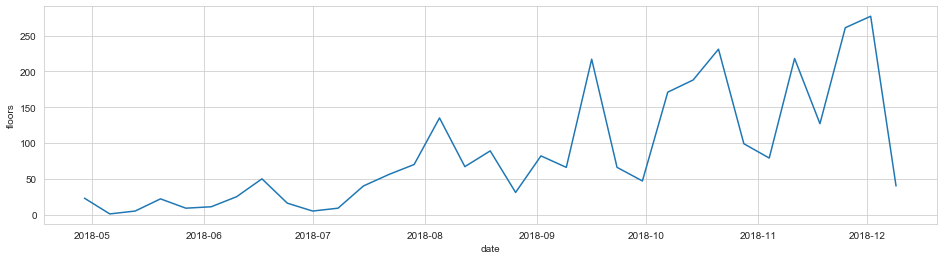

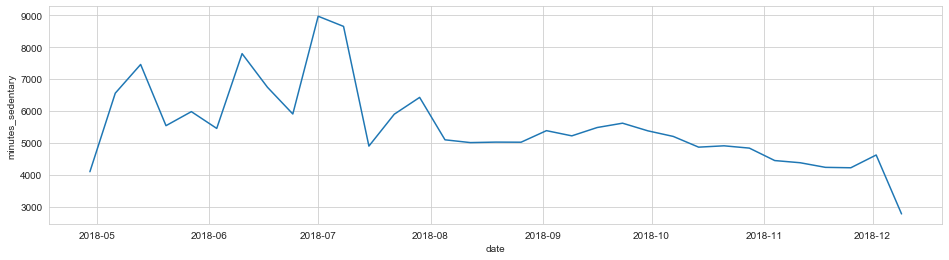

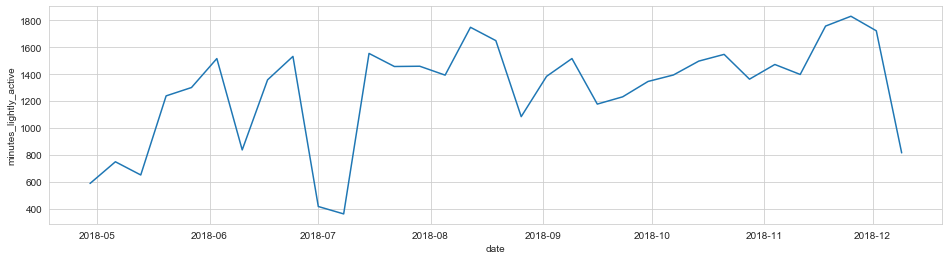

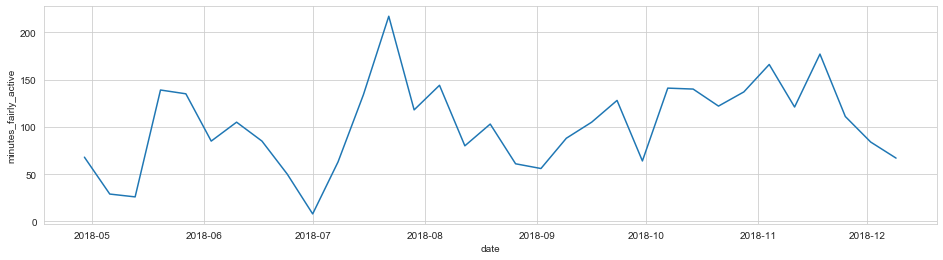

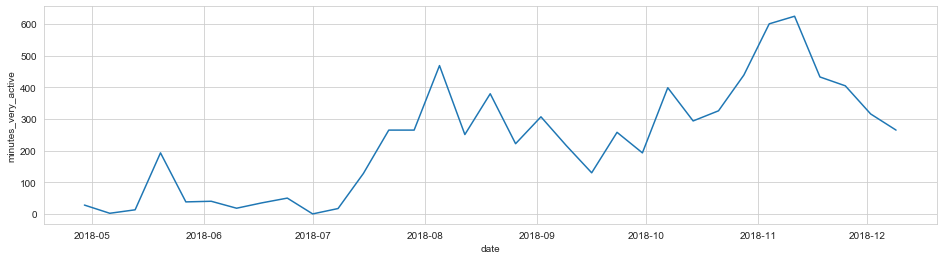

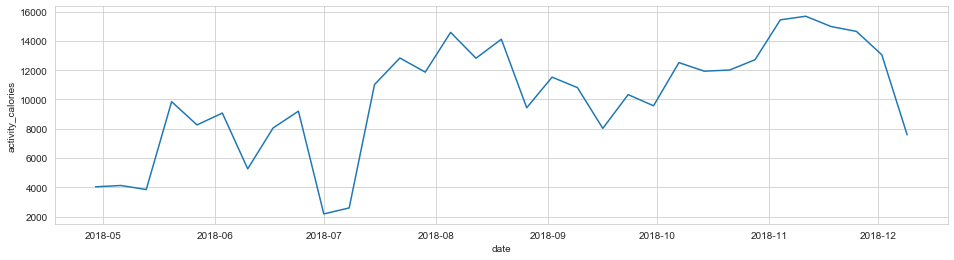

In [12]:
# Resample by week
explore.plot_columns(prep_df)

**Takeaways:** Notice the drastic drop off in November and into December 2018 for nearly all the variables' values when reshaped by week. I'll continue to explore this time period.

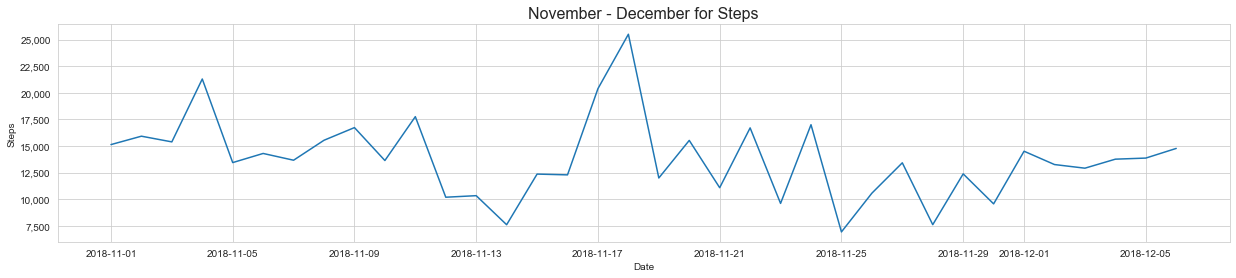

In [50]:
# November - December for steps
plt.figure(figsize = (21,4))
plt.plot(prep_df['steps']['2018-11-01':'2018-12-06'])
plt.xlabel('Date')
plt.ylabel('Steps')
plt.title('November - December for Steps', fontsize = 16)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

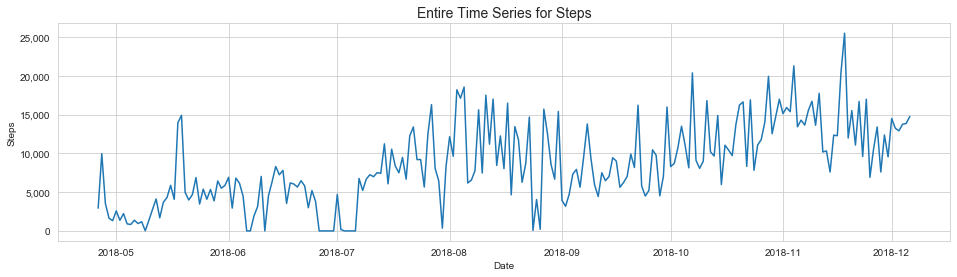

In [48]:
# Entire time series for steps
plt.figure(figsize = (16,4))
plt.plot(prep_df['steps'])
plt.xlabel('Date')
plt.ylabel('Steps')
plt.title('Entire Time Series for Steps', fontsize = 14)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

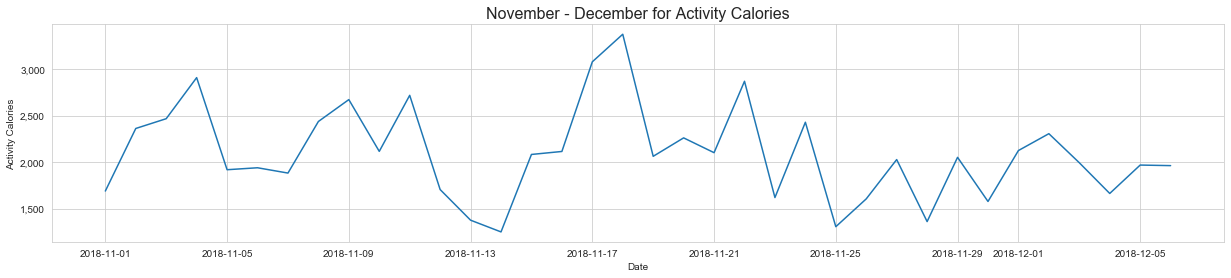

In [47]:
# November - December for activity calories
plt.figure(figsize = (21,4))
plt.plot(prep_df['activity_calories']['2018-11-01':'2018-12-06'])
plt.xlabel('Date')
plt.ylabel('Activity Calories')
plt.title('November - December for Activity Calories', fontsize = 16)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

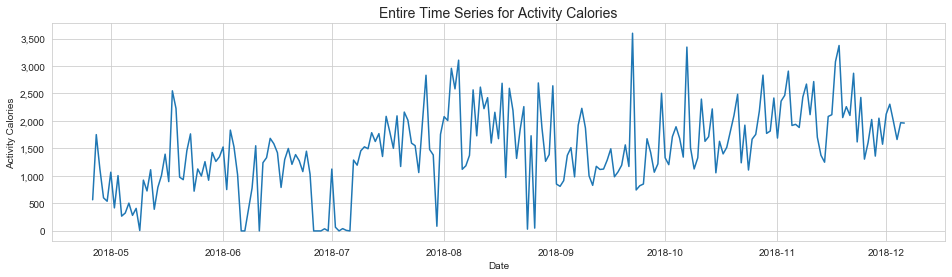

In [43]:
# Entire time series for activity calories
plt.figure(figsize = (16,4))
plt.plot(prep_df['activity_calories'])
plt.xlabel('Date')
plt.ylabel('Activity Calories')
plt.title('Entire Time Series for Activity Calories', fontsize = 14)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

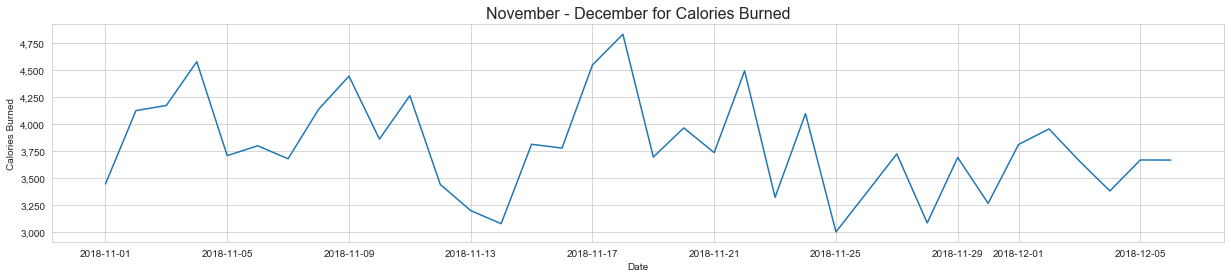

In [45]:
# November - December for calories burned
plt.figure(figsize = (21,4))
plt.plot(prep_df['calories_burned']['2018-11-01':'2018-12-06'])
plt.xlabel('Date')
plt.ylabel('Calories Burned')
plt.title('November - December for Calories Burned', fontsize = 16)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

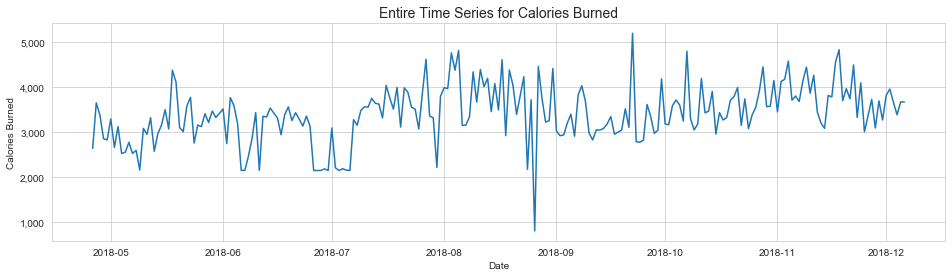

In [40]:
# Entire time series for calories burned
plt.figure(figsize = (16,4))
plt.plot(prep_df['calories_burned'])
plt.xlabel('Date')
plt.ylabel('Calories Burned')
plt.title('Entire Time Series for Calories Burned', fontsize = 14)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

**Task:** Explore number of steps and the relation to calories

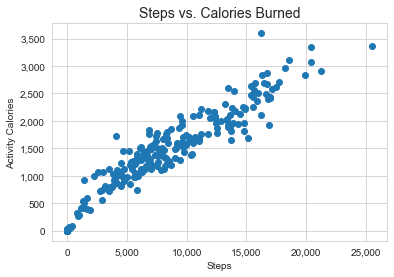

In [38]:
plt.scatter(prep_df['steps'], prep_df['activity_calories'])
plt.title('Steps vs. Calories Burned', fontsize = 14)
plt.xlabel('Steps')
plt.ylabel('Activity Calories')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

**Task:** Explore distance in float and the relation to calories

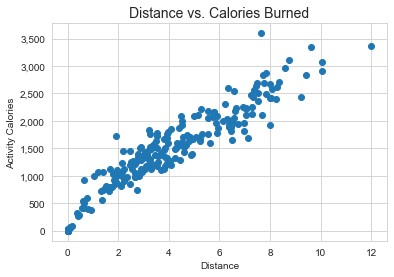

In [39]:
plt.scatter(prep_df['distance'], prep_df['activity_calories'])
plt.title('Distance vs. Calories Burned', fontsize = 14)
plt.xlabel('Distance')
plt.ylabel('Activity Calories')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

**Takeaways:** Obviously distance and steps are very correlated but figuring out who wore the tracking device is not obvious

In [32]:
prep_df.corr()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
calories_burned,1.000000,0.887355,0.884708,0.263060,-0.572117,0.757374,0.619926,0.789379,0.974944
steps,0.887355,1.000000,0.998907,0.336603,-0.633768,0.644159,0.554991,0.907570,0.941876
distance,0.884708,0.998907,1.000000,0.334290,-0.633868,0.641748,0.549097,0.907409,0.939948
floors,0.263060,0.336603,0.334290,1.000000,-0.225786,0.217456,0.139695,0.346969,0.306165
minutes_sedentary,-0.572117,-0.633768,-0.633868,-0.225786,1.000000,-0.640055,-0.321540,-0.478779,-0.646972
minutes_lightly_active,0.757374,0.644159,0.641748,0.217456,-0.640055,1.000000,0.414857,0.338583,0.780967
minutes_fairly_active,0.619926,0.554991,0.549097,0.139695,-0.321540,0.414857,1.000000,0.448323,0.632311
minutes_very_active,0.789379,0.907570,0.907409,0.346969,-0.478779,0.338583,0.448323,1.000000,0.826950
activity_calories,0.974944,0.941876,0.939948,0.306165,-0.646972,0.780967,0.632311,0.826950,1.000000
